# Quick start - Planar graphs

In [2]:
import numpy as np
import networkx as nx
import math
import time
import pickle as pkl
import scipy
import sys
sys.path.insert(0, '/home/azzolin/AHK')
import utils

from ahk import AHK_graphon
from ahk_generators import data_colors, ahk_sbm, sample_data

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from scipy.spatial import Delaunay
from torch.utils.data import Dataset
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
import torch

# Define Planar graphs

In [6]:
class PlanarDataset(Dataset):
    def __init__(self, n_nodes, n_graphs, k, same_sample=False, SON=False, ignore_first_eigv=False):
        self.k = k
        self.ignore_first_eigv = ignore_first_eigv
        
        self.adjs = []
        self.eigvals = []
        self.eigvecs = []
        self.n_nodes = []
        self.max_eigval = 0
        self.min_eigval = 0
        self.same_sample = same_sample
        for i in range(n_graphs):
            # Generate planar graphs using Delauney traingulation
            points = np.random.rand(n_nodes,2)
            tri = Delaunay(points)
            adj = np.zeros([n_nodes,n_nodes])
            for t in tri.simplices:
                adj[t[0], t[1]] = 1
                adj[t[1], t[2]] = 1
                adj[t[2], t[0]] = 1
                adj[t[1], t[0]] = 1
                adj[t[2], t[1]] = 1
                adj[t[0], t[2]] = 1
            G = nx.from_numpy_array(adj)
            adj = torch.from_numpy(adj).float()
            
            self.adjs.append(adj)
            self.n_nodes.append(len(G.nodes()))
        self.n_max = n_nodes

    def __len__(self):
        return len(self.adjs)

    def __getitem__(self, idx):
        if self.same_sample:
            idx = self.__len__() - 1
        graph = {}
        graph["n_nodes"] = self.n_nodes[idx]
        size_diff = self.n_max - graph["n_nodes"]
        graph["adj"] = F.pad(self.adjs[idx], [0, size_diff, 0, size_diff])
        if self.ignore_first_eigv:
            size_diff += 1
        graph["mask"] = F.pad(torch.ones_like(self.adjs[idx]), [0, size_diff, 0, size_diff]).long()
        return graph

## Learning

In [11]:
NUM_GRAPHS = 100

traindata = []
fmap = {
    "features": {
        0: 0,
        1: 1
    }
}

G = PlanarDataset(n_nodes=20, n_graphs=NUM_GRAPHS, k=2)
for i in range(NUM_GRAPHS):
    g = nx.from_numpy_array(G[i]["adj"].numpy())
    nx.set_node_attributes(g, 1, "features") # add required node feature by AHK
    g = utils.nx_to_world(g, featmaps=fmap)
    traindata.append(g)
print(g.sig.unaries)


# Initializing a model. This requires to define the histogram partitioning of the [0,1] interval
# that the model uses
# The first argument in the constructor is the signature of the graphs we are dealing with, i.e.
# a specification of the attributes and relations


binbounds = utils.uni_bins(3)
model_learned = AHK_graphon(traindata[0].sig, binbounds)

# Defining settings:
settings={}
settings['num_pi_b']=50
settings['batchsize']=10
settings['soft']=0.01
settings['numepochs']=30
settings['learn_bins']=False
settings['early_stop']=5
settings['with_trace']=False

#Adam params:
settings['ad_alpha']=0.01
settings['ad_beta1']=0.99
settings['ad_beta2']=0.9
settings['ad_epsilon']=10e-8

settings['method']="adam"

[2]


In [12]:
# Random initialization and learning
model_learned.rand_init()
best, loglik, trace = model_learned.learn(settings, traindata)

100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


Epoch 1 log-lik:  -11675.331642309353 early_stop:  5 noimprov:  0


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


Epoch 2 log-lik:  -11459.770586933473 early_stop:  5 noimprov:  0


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


Epoch 3 log-lik:  -11229.58103276288 early_stop:  5 noimprov:  0


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


Epoch 4 log-lik:  -11229.799444550627 early_stop:  5 noimprov:  1


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


Epoch 5 log-lik:  -11272.595420464677 early_stop:  5 noimprov:  2


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


Epoch 6 log-lik:  -11026.081915580178 early_stop:  5 noimprov:  0


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


Epoch 7 log-lik:  -11036.679269454138 early_stop:  5 noimprov:  1


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


Epoch 8 log-lik:  -11028.734759135026 early_stop:  5 noimprov:  2


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


Epoch 9 log-lik:  -11043.067644487903 early_stop:  5 noimprov:  3


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


Epoch 10 log-lik:  -11205.57150694415 early_stop:  5 noimprov:  4


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]

Epoch 11 log-lik:  -11235.28641371824 early_stop:  5 noimprov:  5


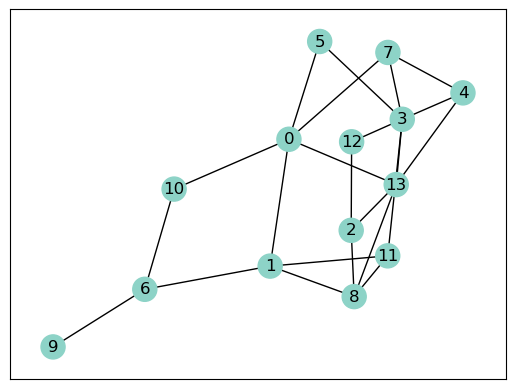

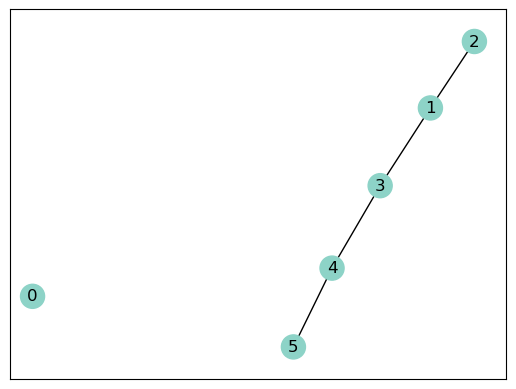

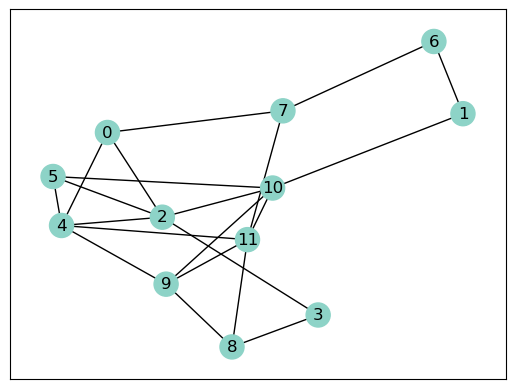

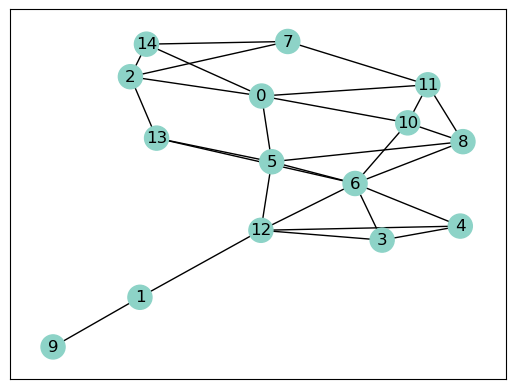

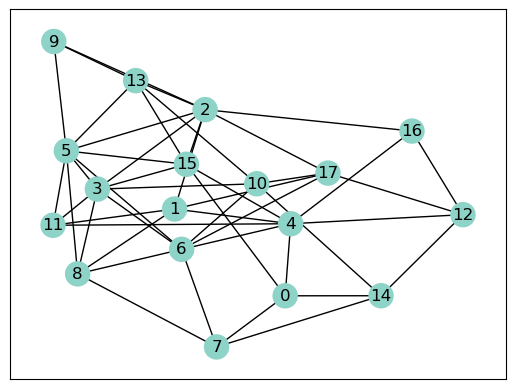

In [15]:
sample = sample_data(model_learned, 5, 5, 20)

for g in sample:
   gnx=g.to_nx()
   nodecols=(list(gnx.nodes()[j]['features'] for j in gnx.nodes()))
   nx.draw_networkx(gnx,node_color=nodecols,cmap='Set3')
   plt.show()

# How many generated graph are actually planar?

In [16]:
[nx.is_planar(g.to_nx()) for g in sample]

[True, True, False, False, False]